# Machine Learning Final Project - Zach Quintanilla
## Instructor - Dr. Micheal Pyrcz
## TA - Jack Xiao

### Introduction

The goal of this project is to perform Principal Component Analysis on a data set that exhibits  multicollinearity to execute dimensionality reduction. After demensionality reduction, we will compare the utilization of both polynomial regression and support vector machines to predict the response feature, production. Another major motivation is see how the response feature will behave in the PCA deminsional space.

By using 3 Principal Components we were able to explain 90% of the variance within the data set and were able to obtain an regression model and a decent categorical model. 

Overall, the regression model using hermite polynomials and polynomial regression appears to have had greater success in predicting the response feature, production.

#### Data Prep
We will first start by importing packages relevent to the analysis

In [1]:
import numpy as np                                                                            
import pandas as pd                                        
import matplotlib.pyplot as plt                             
from sklearn.decomposition import PCA                    
from sklearn.preprocessing import StandardScaler         
from scipy import stats   
import scipy
import seaborn as sns  
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics    
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC   
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

Next, we will load the data file provided by Dr.Pyrcz.

In [2]:
data = pd.read_csv("GeoDataSets-master/unconv_MV_v2.csv")                   #Provided by Dr.Pyrcz 
data = data.iloc[:,1:]                               
data.head()

,Por,LogPerm,AI,Brittle,TOC,VR,Production,Prod2Scaled
0,15.91,1.67,3.06,14.05,1.36,1.85,177.381958,1897.657798
1,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778,2745.732996
2,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583,5835.130524
3,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629,2132.237219
4,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919,6282.254735


Now, we will look at the correlation matrix and summary statistics.

In [3]:
corr_matrix = np.corrcoef(data.iloc[:,:6], rowvar = False)
print('Correlation Matrix of the Features')
print(np.around(corr_matrix,2)) 
data.describe()

Correlation Matrix of the Features
[[ 1.    0.81 -0.51 -0.25  0.71  0.08]
 [ 0.81  1.   -0.32 -0.14  0.51  0.05]
 [-0.51 -0.32  1.    0.16 -0.55  0.49]
 [-0.25 -0.14  0.16  1.   -0.24  0.29]
 [ 0.71  0.51 -0.55 -0.24  1.    0.31]
 [ 0.08  0.05  0.49  0.29  0.31  1.  ]]


,Por,LogPerm,AI,Brittle,TOC,VR,Production,Prod2Scaled
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14.950460,1.398880,2.982610,49.769980,1.003810,1.991170,2247.295809,3237.154325
std,3.029634,0.405966,0.577629,14.944955,0.504978,0.308194,1464.256312,1507.552730
min,5.400000,0.120000,0.960000,3.030000,-0.260000,0.900000,2.713535,2.713535
25%,12.857500,1.130000,2.577500,39.722500,0.640000,1.810000,1191.369560,2120.961071
50%,14.985000,1.390000,3.010000,49.680000,0.995000,2.000000,1976.487820,2991.762748
75%,17.080000,1.680000,3.360000,59.170000,1.360000,2.172500,3023.594214,4105.623405
max,24.650000,2.580000,4.700000,93.470000,2.710000,2.900000,12568.644130,12568.644130


We can see that some multicollinearity exists within the data set  so we will now visualize with pairplots.

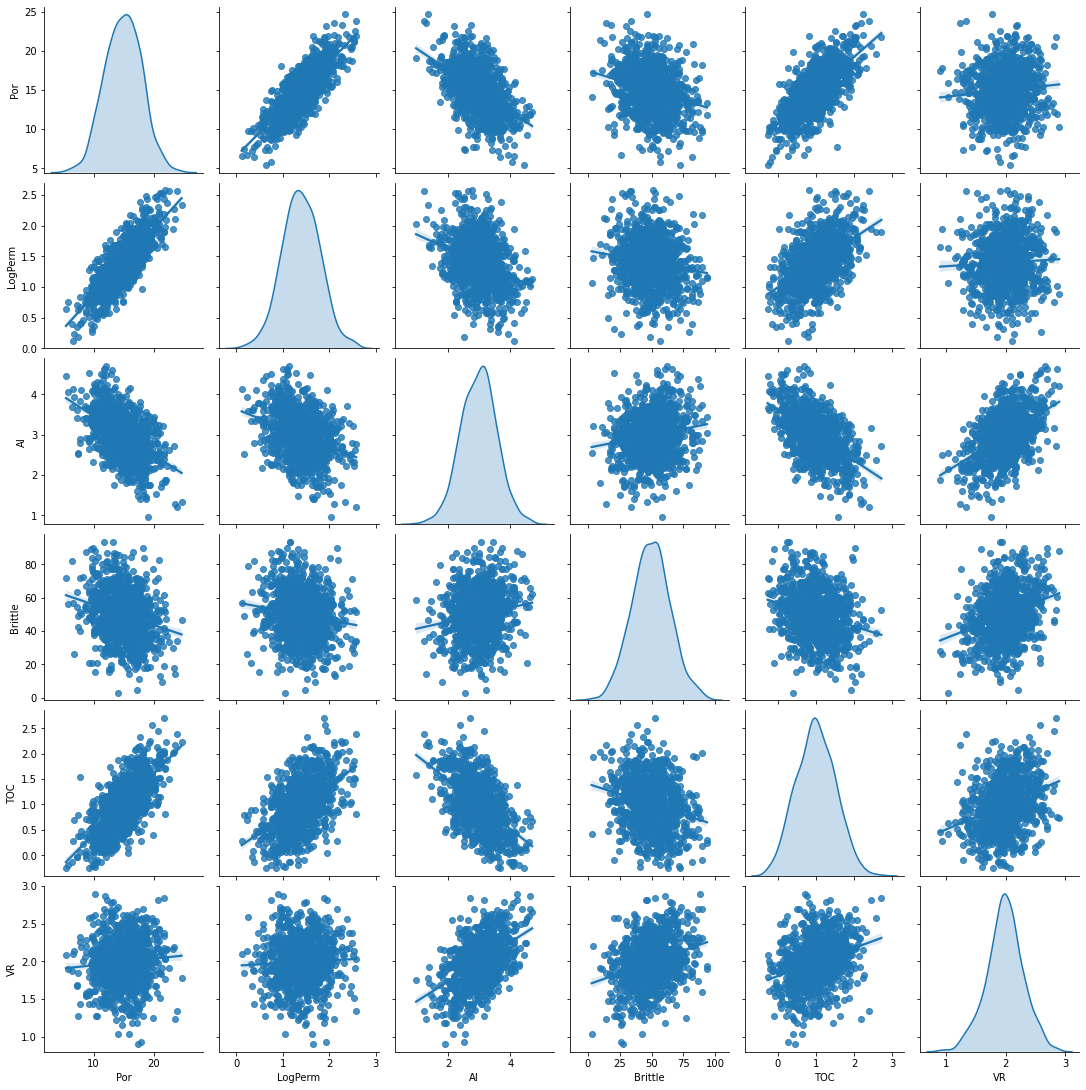

In [4]:
sns.pairplot(data.iloc[:,:6],vars=['Por','LogPerm','AI','Brittle','TOC','VR'],markers='o', kind='reg',diag_kind='kde' )

Now that we have visualized the features, we will prepare the data by standardizing the data, a requirement for principal component analysis. Additionally, we will categorize the production into low (x<1500), medium (1500<x<2750), and high (2750<x) categories.

In [5]:
response_feature = data.iloc[:,6]
cat_response_feature = np.empty((len(response_feature),1))
for i in range(0,len(response_feature)):                    
    if response_feature[i]<1500:
        cat_response_feature[i] = 1
    elif response_feature[i]>1500 and response_feature[i]<2750:
        cat_response_feature[i] = 2
    elif response_feature[i]>2750:
        cat_response_feature[i] = 3
pred_data = data.iloc[:,:6]
mean = np.mean(pred_data, axis = 0).values
std = np.std(pred_data, axis = 0).values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.iloc[:,:7])   
scaled_pred_data = pd.DataFrame(scaled_data[:,:6],columns =['Por','LogPerm','AI','Brittle','TOC','VR'])

scaled_response_feature = pd.DataFrame(scaled_data[:,6],columns =['Production'])
scaled_pred_data.describe()

,Por,LogPerm,AI,Brittle,TOC,VR
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,1.186273e-16,-2.957079e-16,4.085621e-16,2.347011e-16,2.389755e-16,-3.831380e-16
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-3.153925e+00,-3.151793e+00,-3.503327e+00,-3.129040e+00,-2.503956e+00,-3.542302e+00
25%,-6.911749e-01,-6.626534e-01,-7.016838e-01,-6.726355e-01,-7.208080e-01,-5.881382e-01
50%,1.140642e-02,-2.188471e-02,4.744173e-02,-6.023773e-03,-1.745504e-02,2.866513e-02
75%,7.032550e-01,6.928188e-01,6.536705e-01,6.292908e-01,7.057107e-01,5.886577e-01
max,3.203157e+00,2.910864e+00,2.974660e+00,2.925528e+00,3.380433e+00,2.950365e+00


#### Principal Component Analysis (PCA)
We have successfully standardized the data and will now apply PCA.

In [6]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(scaled_pred_data)

PCA(n_components=6)

Next we will analyze the variance explained by each principle component.

In [7]:
print('Variance explained by Principle Component =', np.round(pca.explained_variance_ratio_,3))

Variance explained by Principle Component = [0.47  0.249 0.143 0.106 0.023 0.009]


From the variance we can see that nearly 90% of the variance is explained by the first 3 principal components. This will be useful in our efforts to make a resonable 3d model.

We will now transform the features and look at the new correlation matrix

In [8]:
PCA_data = pca.transform(scaled_pred_data)
print('\nCorrelation Matrix of the Principal Components:')
print(np.round(np.corrcoef(PCA_data, rowvar = False),2))


Correlation Matrix of the Principal Components:
[[ 1.  0. -0. -0.  0. -0.]
 [ 0.  1.  0. -0. -0.  0.]
 [-0.  0.  1.  0.  0.  0.]
 [-0. -0.  0.  1. -0.  0.]
 [ 0. -0.  0. -0.  1.  0.]
 [-0.  0.  0.  0.  0.  1.]]


We can now see that we have removed the multicollinearity from the data set

#### Data Visualization

First, we will reduce to 2 principle components to see if it is a viable to only use 2 components.

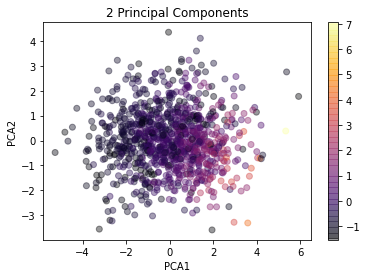

In [9]:
%matplotlib inline
fig2,ax2 = plt.subplots()

graph = ax2.scatter(PCA_data[:,0],PCA_data[:,1], c=scaled_response_feature.iloc[:,0], marker=None, cmap='inferno', alpha=.4)

fig2.colorbar(graph); ax2.set_title('2 Principal Components'); ax2.set_xlabel('PCA1'); ax2.set_ylabel('PCA2')
plt.show()

We can see that using 2 principle components is insufficent for analyzing this data set due to significant overlap. We will now attempt to visualize in 3d with the response feature. Using %matplotlib notebook we can interactivly move the 3D figure to have a better understanding of the data. (This will likely need to be run 1 or 2 times after the intital run to appear)

<IPython.core.display.Javascript object>


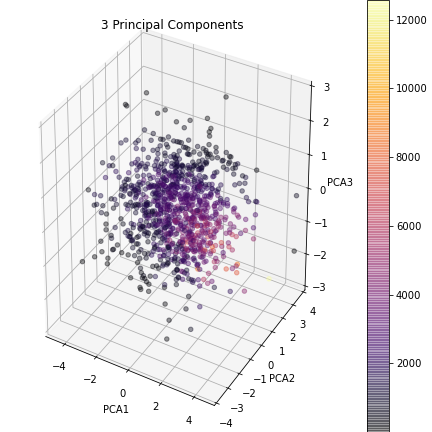

In [25]:
%matplotlib notebook
fig3 = plt.figure(figsize=(6,6))
ax3 = Axes3D(fig3) 
graph3 = ax3.scatter(PCA_data[:,0],PCA_data[:,1],PCA_data[:,2], c=response_feature, marker=None, cmap='inferno', alpha=.4)
graph.set_clim([0,12000]); fig3.colorbar(graph3); ax3.set_title('3 Principal Components'); ax3.axes.set_xlim3d(left=-5, right=5); ax3.set_xlabel('PCA1'); ax3.axes.set_ylim3d(bottom=-4, top=4); ax3.set_ylabel('PCA2'); ax3.axes.set_zlim3d(bottom=-3, top=3); ax3.set_zlabel('PCA3')
plt.show()

This is visualization is somewhat hard to understand so we will attempt to better visualize by plotting the categorical response feature (Low=1, Medium=2, High=3)

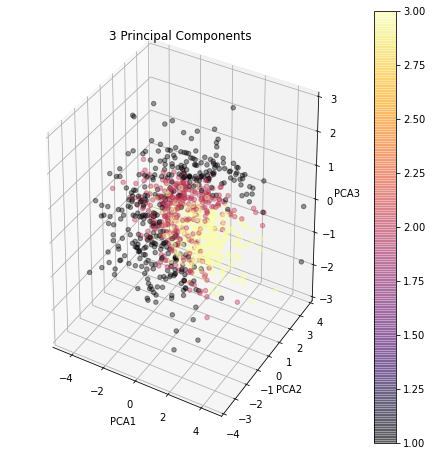

In [11]:
%matplotlib inline
CAT_data = np.concatenate((PCA_data,cat_response_feature), axis = 1)
fig_cat = plt.figure(figsize=(6,6))
ax_cat = Axes3D(fig_cat) 

graph_cat = ax_cat.scatter(CAT_data[:,0],CAT_data[:,1],CAT_data[:,2], c=CAT_data[:,-1], marker=None, cmap='inferno', alpha=.4)

fig_cat.colorbar(graph_cat); ax_cat.set_title('3 Principal Components'); ax_cat.axes.set_xlim3d(left=-5, right=5); ax_cat.set_xlabel('PCA1'); ax_cat.axes.set_ylim3d(bottom=-4, top=4); ax_cat.set_ylabel('PCA2'); ax_cat.axes.set_zlim3d(bottom=-3, top=3); ax_cat.set_zlabel('PCA3')
plt.show()

We can see, with a little more clarity, the trend in the data. Within the "sphere of data" there appears to be two "bowls" surrounding a smaller sphere which indicated category 3 ei high production. We will further visualize by breaking each visualization by categorical response. We can see from the graphs that the production is evenly split between the three categories.

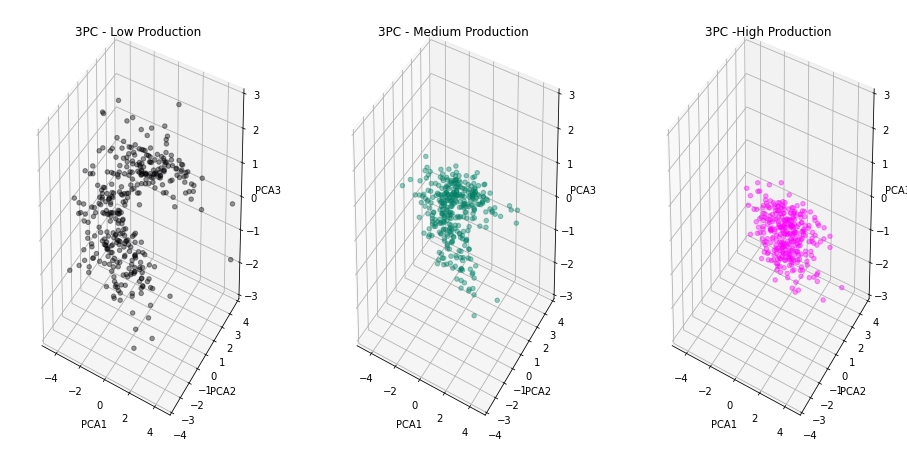

The number of wells with low production is: 354
The number of wells with medium production is: 340
The number of wells with high production is: 306


In [12]:
fig_a = plt.figure(figsize=(16,8))
ax_a = fig_a.add_subplot(1,3,1, projection = '3d')

ax_a.scatter(CAT_data[CAT_data[:,-1]==1,0],CAT_data[CAT_data[:,-1]==1,1],CAT_data[CAT_data[:,-1]==1,2], c=CAT_data[CAT_data[:,-1]==1,-1], marker=None, cmap='inferno', alpha=.4)
ax_a.set_title('3PC - Low Production'); ax_a.axes.set_xlim3d(left=-5, right=5); ax_a.set_xlabel('PCA1'); ax_a.axes.set_ylim3d(bottom=-4, top=4) ; ax_a.set_ylabel('PCA2'); ax_a.axes.set_zlim3d(bottom=-3, top=3) ; ax_a.set_zlabel('PCA3')

ax_b = fig_a.add_subplot(1,3,2, projection = '3d')

ax_b.scatter(CAT_data[CAT_data[:,-1]==2,0],CAT_data[CAT_data[:,-1]==2,1],CAT_data[CAT_data[:,-1]==2,2], c=CAT_data[CAT_data[:,-1]==2,-1], marker=None, cmap='summer', alpha=.4)
ax_b.set_title('3PC - Medium Production'); ax_b.axes.set_xlim3d(left=-5, right=5); ax_b.set_xlabel('PCA1'); ax_b.axes.set_ylim3d(bottom=-4, top=4); ax_b.set_ylabel('PCA2'); ax_b.axes.set_zlim3d(bottom=-3, top=3); ax_b.set_zlabel('PCA3')

ax_c = fig_a.add_subplot(1,3,3, projection = '3d')

ax_c.scatter(CAT_data[CAT_data[:,-1]==3,0],CAT_data[CAT_data[:,-1]==3,1],CAT_data[CAT_data[:,-1]==3,2], c=CAT_data[CAT_data[:,-1]==3,-1], marker=None, cmap='spring', alpha=.4)
ax_c.set_title('3PC -High Production'); ax_c.axes.set_xlim3d(left=-5, right=5); ax_c.set_xlabel('PCA1'); ax_c.axes.set_ylim3d(bottom=-4, top=4); ax_c.set_ylabel('PCA2'); ax_c.axes.set_zlim3d(bottom=-3, top=3); ax_c.set_zlabel('PCA3')
plt.show()

print(f'The number of wells with low production is: {np.count_nonzero(CAT_data[:,-1]==1)}')
print(f'The number of wells with medium production is: {np.count_nonzero(CAT_data[:,-1]==2)}')
print(f'The number of wells with high production is: {np.count_nonzero(CAT_data[:,-1]==3)}')

We will now split the data into training and testing data in preparation for regression modeling.

In [13]:
num_features = 3
X_train, X_test, y_train, y_test = train_test_split(PCA_data[:,:num_features], np.array(scaled_response_feature), test_size=0.15, random_state=117)

### Polynomial Regression with Hermite Polynomials

Now we will attempt to use Hermite Polynomials to perform a regression analysis. Due to the high mean squared error of some models, we will will not visualize MSE (mean squared error) over a threshold value of 1.2 so that we can get a resonable color scale.

The optimal hermite order is: 1
The optimal polynomial order is: 5
The optimal mean squared error is 0.0010813390965471116


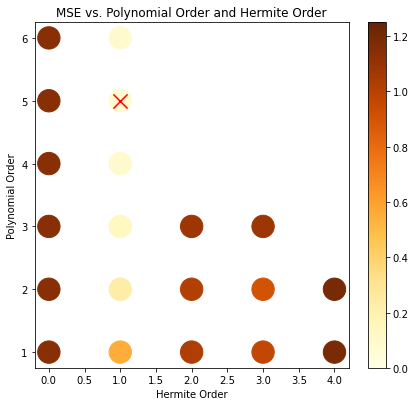

In [14]:
orders = [0,1,2,3,4] 
poly_order =[1,2,3,4,5,6]
hermite_error = np.zeros([len(orders),len(poly_order)])
hermite_r2 = np.zeros([len(orders),len(poly_order)])
for i in orders:
    hermite_train = scipy.special.eval_hermitenorm(i, X_train, out=None) 
    hermite_test= scipy.special.eval_hermitenorm(i, X_test, out=None) 

    for j in poly_order:
        hermite = Pipeline([('poly', PolynomialFeatures(degree=j)),('linear', LinearRegression())])
        hermite.fit(hermite_train, y_train) 
        hermite_pred = hermite.predict(scipy.special.eval_hermitenorm(i, X_test, out=None))
        #mse error
        if mean_squared_error(y_test,hermite_pred) < 3:
            hermite_error[orders.index(i),poly_order.index(j)] = mean_squared_error(y_test,hermite_pred)
        #variance
        hermite_r2[orders.index(i),poly_order.index(j)] = r2_score(y_test,hermite_pred)


fig8, ax8 = plt.subplots()
hermite_error[hermite_error == 0] = np.amax(hermite_error)
row, col = np.unravel_index(hermite_error.argmin(), hermite_error.shape)
poly_orderp, ordersp = np.meshgrid(poly_order,orders)
plot_data = np.dstack((ordersp,poly_orderp,hermite_error))
print(f'The optimal hermite order is: {row}')
print(f'The optimal polynomial order is: {col+1}')

cutoff = 1.2
plt.subplot(121)
hermite_plot = plt.scatter(plot_data[:,:,0][plot_data[:,:,2]<cutoff],plot_data[:,:,1][plot_data[:,:,2]<cutoff], c = plot_data[:,:,2][plot_data[:,:,2]<cutoff], s = 500, cmap = 'YlOrBr')
cbar_herm = plt.colorbar(hermite_plot, orientation = 'vertical');
plt.clim([0,1.25])
plt.scatter(row,col+1,color = 'r', marker = 'x', s = 200)
plt.title('MSE vs. Polynomial Order and Hermite Order'); plt.xlabel('Hermite Order'); plt.ylabel('Polynomial Order')


#Evaluate at optimal order
optherm_train = scipy.special.eval_hermitenorm(row, PCA_data, out=None) 
optherm_test= scipy.special.eval_hermitenorm(row, PCA_data, out=None) 
optherm = Pipeline([('poly', PolynomialFeatures(degree=col+1)),('linear', LinearRegression())])
optherm.fit(optherm_train, scaled_response_feature[:])     
hermite_pred = optherm.predict(scipy.special.eval_hermitenorm(row, PCA_data, out=None))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
print(f'The optimal mean squared error is {mean_squared_error(scaled_response_feature[:],hermite_pred)}')

We can see that we obtain a low MSE value with the regression analysis. Now we will plot the the original data set as well as the inverse_transformed predicted response feature, production, vs. the three principal components.

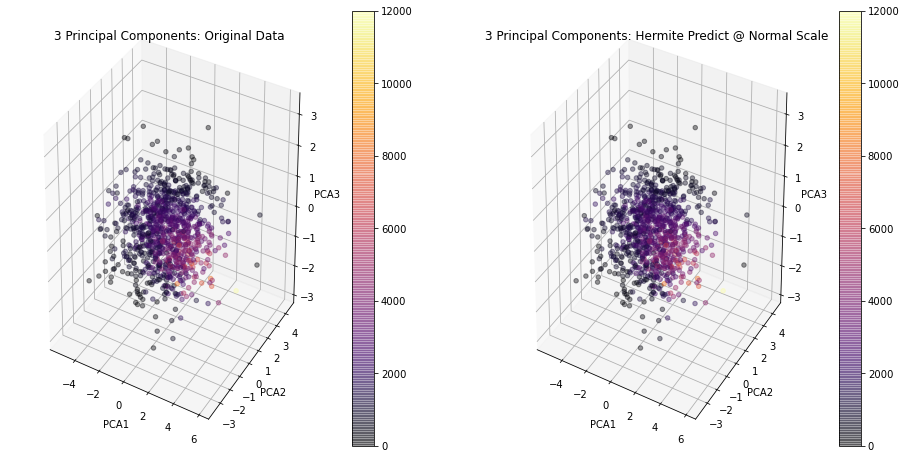

In [15]:
fig9 = plt.figure(figsize=(16,8))

ax9 = fig9.add_subplot(1,2,1, projection = '3d')
orig_model = ax9.scatter(PCA_data[:,0],PCA_data[:,1],PCA_data[:,2], c=response_feature, marker=None, cmap='inferno', alpha=.4)
orig_model.set_clim([0,12000]); fig9.colorbar(orig_model); ax9.set_title('3 Principal Components: Original Data'); ax9.set_xlabel('PCA1'); ax9.set_ylabel('PCA2'); ax9.set_zlabel('PCA3')

fitted_data = np.column_stack((scaled_pred_data,hermite_pred.reshape(1000,1)))
predict_prod = scaler.inverse_transform(fitted_data)

ax10 = fig9.add_subplot(1,2,2, projection = '3d')
reg_model = ax10.scatter(PCA_data[:,0],PCA_data[:,1],PCA_data[:,2], c=predict_prod[:,-1], marker=None, cmap='inferno', alpha=.4)
reg_model.set_clim([0,12000]); fig9.colorbar(reg_model); ax10.set_title('3 Principal Components: Hermite Predict @ Normal Scale'); ax10.set_xlabel('PCA1'); ax10.set_ylabel('PCA2'); ax10.set_zlabel('PCA3')
plt.show()

It appears the polynomial regression performs well. As a final step, we will plot the residuals.

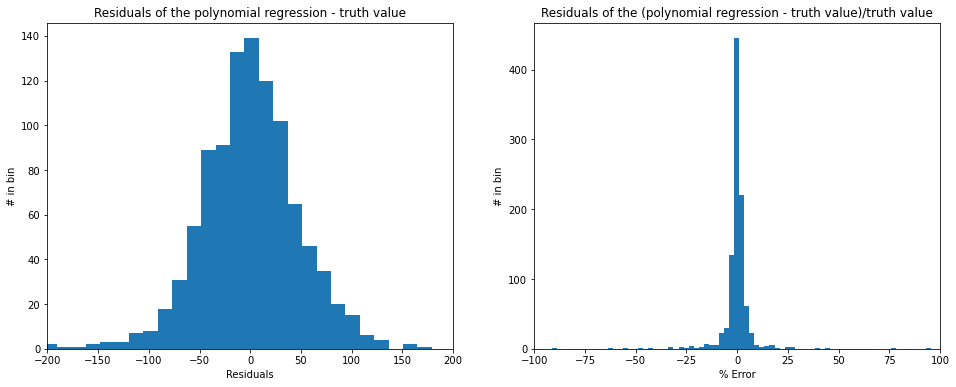

The number of predictions within +/- 100 is : 956
The number of predictions within +/- 10% Error is : 942
The number of predictions within +/- 20% Error is : 973


In [16]:
residuals = predict_prod[:,-1]-response_feature
residuals_percent = residuals/response_feature*100
fig11, ax11 = plt.subplots(figsize = (16,6))

plt.subplot(121)
plt.hist(residuals, bins = 30)
plt.title('Residuals of the polynomial regression - truth value'); plt.xlabel('Residuals'); plt.ylabel('# in bin'),plt.xlim([-200,200])

plt.subplot(122)
plt.hist(residuals_percent[abs(residuals_percent)<101], bins = 75)
plt.title('Residuals of the (polynomial regression - truth value)/truth value'); plt.xlabel('% Error'); plt.xlim([-100,100]); plt.ylabel('# in bin')
plt.show()

print(f'The number of predictions within +/- 100 is : {np.count_nonzero(abs(predict_prod[:,-1]-response_feature)<100)}')
print(f'The number of predictions within +/- 10% Error is : {np.count_nonzero(abs(residuals_percent)<10)}')
print(f'The number of predictions within +/- 20% Error is : {np.count_nonzero(abs(residuals_percent)<20)}')

#### Analysis of Polynomial Regression

From the histogram of the residuals, we can see that most of the residuals (over 90%) lies between +/- 100 which is 4% of the mean of the data set, ~2250. Additionally we can see that the residuals are normally distrubited around zero. However, due to the range in the nominal value of production data, the nominal residuals does not provide as much clarity as a small residual paired with a small production prediction may lead to a high % error. The same is true that a high residual paired with a high production value may actually lead to a low % error. Therefore, we will relay on the residuals of the error to determine the fit of our model.
   
We can see from the residuals of the error that nearly 95% of the time we are within 10% of the truth value and nearly 97.5% of the time we are within 20% of the truth value. This, paired with a low MSE ,would support that this is a strong model for predicting the response feature, production.

### Support Vector Machines (SVM)

We will now see how support vector machines behaves. Since this is categorical we cannot use MSE to determine best fit so we will use the f1 score which is the harmonic mean of precision and recall. Precision is defined as the total number of true positives divided by the total number of positives for the predicted category. Recall is defined as the number true positives divided by the total number of the original category. Additionally, we will optimize the C parameter which is the regularization parameter that controls the penatly associated with misclassification. We will utilize the same test_size of 0.15 for comparison. 

In [17]:
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(CAT_data[:,:num_features], np.array(CAT_data[:,-1]), test_size=0.15, random_state=117)
C = np.linspace(11,40,30)
degree = np.linspace(1,5,5)
f_score = np.zeros([len(degree),len(C)])
for i in range(0,len(degree)):
    for j in range(0,len(C)):
        SVM_Model = SVC(kernel = 'poly', degree = degree[i], random_state = 117, C = C[j])
        SVM_Model.fit(Xcat_train, ycat_train)
        ysvm_predict = SVM_Model.predict(Xcat_test)
        f_score[i,j] = f1_score(ycat_test, ysvm_predict, average='macro')

We will now visualize the f1 score metric vs C and degree power and obtain the exact values of degree, C, and maximum f1 score so that we can build our tuned model.

The optimal degree is 3.0 and the optimal C value is 21.0.
The maximum f1 score is 0.675746965452848


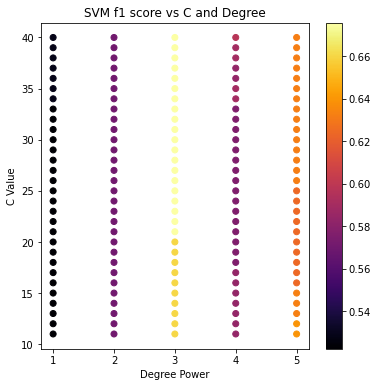

In [18]:
index_degree, index_C = np.unravel_index(f_score.argmax(),f_score.shape)
report_degree  = degree[index_degree]
report_C  = C[index_C]
print(f'The optimal degree is {report_degree} and the optimal C value is {report_C}.')
print(f'The maximum f1 score is {f_score[index_degree,index_C]}')

Cp, degreep = np.meshgrid(C,degree);
fig_svm,ax_svm = plt.subplots(figsize = (6,6))
svm_plot = plt.scatter(degreep,Cp,c=f_score, cmap = 'inferno')
cbar = plt.colorbar(svm_plot, orientation = 'vertical'); plt.title('SVM f1 score vs C and Degree'); plt.xlabel('Degree Power'); plt.ylabel('C Value'); plt.xticks(np.arange(1,6,step = 1))
plt.show()

By visual inspection we can confirm that the 3rd power is optimal. Due to the range of f1 scores, it is hard to determine visually the optimal C value from the plot.

We will now build our tuned model and look at the confusion matrix.

In [19]:
SVM_Model = SVC(kernel = 'poly', degree = degree[index_degree], random_state = 117, C = C[index_C])
SVM_Model.fit(CAT_data[:,:num_features], CAT_data[:,-1])
final_predict = SVM_Model.predict(CAT_data[:,:num_features])
confusion_matrix(CAT_data[:,-1],final_predict)

array([[201, 144,   9],
       [ 20, 310,  10],
       [  7, 127, 172]], dtype=int64)

We can see from the confusion matrix that categories 1 and 3 have reasonable precision but poor recall. The opposite is true for category 2 which has resonable recall but poor precision. We will look into this further with the classification report.

In [20]:
print(classification_report(CAT_data[:,-1], final_predict, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.88      0.57      0.69       354
           2       0.53      0.91      0.67       340
           3       0.90      0.56      0.69       306

    accuracy                           0.68      1000
   macro avg       0.77      0.68      0.69      1000
weighted avg       0.77      0.68      0.69      1000



The classification report confirms our analysis of the confusion matrix. 

Now to visualize the original data set as well as our tuned model in 3D

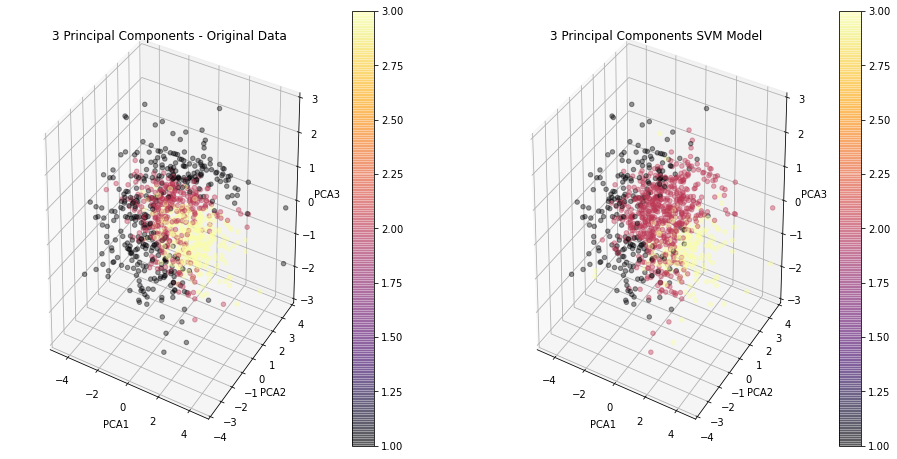

In [21]:
fig_svm = plt.figure(figsize=(16,8))

ax_cat = fig_svm.add_subplot(1,2,1, projection = '3d')
graph_cat = ax_cat.scatter(CAT_data[:,0],CAT_data[:,1],CAT_data[:,2], c=CAT_data[:,-1], marker=None, cmap='inferno', alpha=.4)
fig_svm.colorbar(graph_cat); ax_cat.set_title('3 Principal Components - Original Data'); ax_cat.axes.set_xlim3d(left=-5, right=5); ax_cat.set_xlabel('PCA1'); ax_cat.axes.set_ylim3d(bottom=-4, top=4); ax_cat.set_ylabel('PCA2'); ax_cat.axes.set_zlim3d(bottom=-3, top=3); ax_cat.set_zlabel('PCA3')

ax_svm = fig_svm.add_subplot(1,2,2, projection = '3d')
graph_svm = ax_svm.scatter(CAT_data[:,0],CAT_data[:,1],CAT_data[:,2], c=final_predict, marker=None, cmap='inferno', alpha=.4)
fig_svm.colorbar(graph_svm); ax_svm.set_title('3 Principal Components SVM Model'); ax_svm.axes.set_xlim3d(left=-5, right=5); ax_svm.set_xlabel('PCA1'); ax_svm.axes.set_ylim3d(bottom=-4, top=4); ax_svm.set_ylabel('PCA2'); ax_svm.axes.set_zlim3d(bottom=-3, top=3); ax_svm.set_zlabel('PCA3')

plt.show()

Compared to the original data set, there is a disproportionate amount classified to the 2nd category, medium production. We will, once again, break down the into each category and visualize and compare to the original data set.

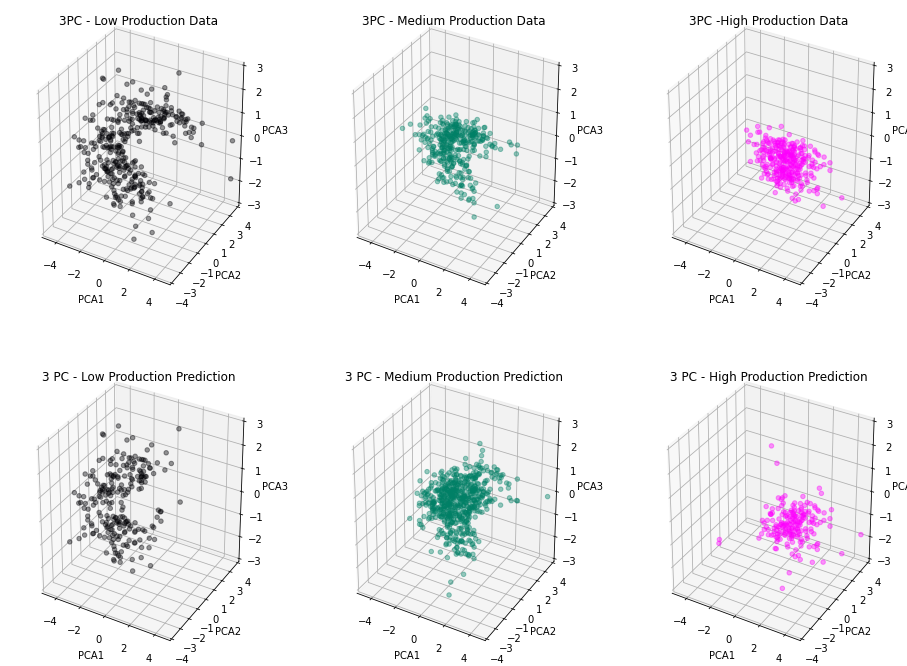

In [22]:
CAT_datap = np.copy(CAT_data)
CAT_datap[:,-1] = final_predict
fig_aa = plt.figure(figsize=(16,12))

ax_a = fig_aa.add_subplot(2,3,1, projection = '3d')

ax_a.scatter(CAT_data[CAT_data[:,-1]==1,0],CAT_data[CAT_data[:,-1]==1,1],CAT_data[CAT_data[:,-1]==1,2], c=CAT_data[CAT_data[:,-1]==1,-1], marker=None, cmap='inferno', alpha=.4)
ax_a.set_title('3PC - Low Production Data'); ax_a.axes.set_xlim3d(left=-5, right=5); ax_a.set_xlabel('PCA1'); ax_a.axes.set_ylim3d(bottom=-4, top=4) ; ax_a.set_ylabel('PCA2'); ax_a.axes.set_zlim3d(bottom=-3, top=3) ; ax_a.set_zlabel('PCA3')

ax_b = fig_aa.add_subplot(2,3,2, projection = '3d')

ax_b.scatter(CAT_data[CAT_data[:,-1]==2,0],CAT_data[CAT_data[:,-1]==2,1],CAT_data[CAT_data[:,-1]==2,2], c=CAT_data[CAT_data[:,-1]==2,-1], marker=None, cmap='summer', alpha=.4)
ax_b.set_title('3PC - Medium Production Data'); ax_b.axes.set_xlim3d(left=-5, right=5); ax_b.set_xlabel('PCA1'); ax_b.axes.set_ylim3d(bottom=-4, top=4); ax_b.set_ylabel('PCA2'); ax_b.axes.set_zlim3d(bottom=-3, top=3); ax_b.set_zlabel('PCA3')

ax_c = fig_aa.add_subplot(2,3,3, projection = '3d')

ax_c.scatter(CAT_data[CAT_data[:,-1]==3,0],CAT_data[CAT_data[:,-1]==3,1],CAT_data[CAT_data[:,-1]==3,2], c=CAT_data[CAT_data[:,-1]==3,-1], marker=None, cmap='spring', alpha=.4)
ax_c.set_title('3PC -High Production Data'); ax_c.axes.set_xlim3d(left=-5, right=5); ax_c.set_xlabel('PCA1'); ax_c.axes.set_ylim3d(bottom=-4, top=4); ax_c.set_ylabel('PCA2'); ax_c.axes.set_zlim3d(bottom=-3, top=3); ax_c.set_zlabel('PCA3')


ax_aa = fig_aa.add_subplot(2,3,4, projection = '3d')
graph_aa = ax_aa.scatter(CAT_datap[CAT_datap[:,-1]==1,0],CAT_datap[CAT_datap[:,-1]==1,1],CAT_datap[CAT_datap[:,-1]==1,2], c=final_predict[final_predict[:]==1], marker=None, cmap='inferno', alpha=.4)
ax_aa.set_title('3 PC - Low Production Prediction'); ax_aa.axes.set_xlim3d(left=-5, right=5); ax_aa.set_xlabel('PCA1'); ax_aa.axes.set_ylim3d(bottom=-4, top=4); ax_aa.set_ylabel('PCA2'); ax_aa.axes.set_zlim3d(bottom=-3, top=3); ax_aa.set_zlabel('PCA3')

ax_bb = fig_aa.add_subplot(2,3,5, projection = '3d')
graph_bb = ax_bb.scatter(CAT_datap[CAT_datap[:,-1]==2,0],CAT_datap[CAT_datap[:,-1]==2,1],CAT_datap[CAT_datap[:,-1]==2,2], c=final_predict[final_predict[:]==2], marker=None, cmap='summer', alpha=.4)
ax_bb.set_title('3 PC - Medium Production Prediction'); ax_bb.axes.set_xlim3d(left=-5, right=5); ax_bb.set_xlabel('PCA1'); ax_bb.axes.set_ylim3d(bottom=-4, top=4); ax_bb.set_ylabel('PCA2'); ax_bb.axes.set_zlim3d(bottom=-3, top=3); ax_bb.set_zlabel('PCA3')

ax_cc = fig_aa.add_subplot(2,3,6, projection = '3d')
graph_cc = ax_cc.scatter(CAT_datap[CAT_datap[:,-1]==3,0],CAT_datap[CAT_datap[:,-1]==3,1],CAT_datap[CAT_datap[:,-1]==3,2], c=final_predict[final_predict[:]==3], marker=None, cmap='spring', alpha=.4)
ax_cc.set_title('3 PC - High Production Prediction'); ax_cc.axes.set_xlim3d(left=-5, right=5); ax_cc.set_xlabel('PCA1'); ax_cc.axes.set_ylim3d(bottom=-4, top=4); ax_cc.set_ylabel('PCA2'); ax_cc.axes.set_zlim3d(bottom=-3, top=3); ax_cc.set_zlabel('PCA3')

plt.show()

#### Analysis of SVM

From this visualization we can confirm that the categorical analysis misclassified a significant portion of the data (~20%) into the second category, medium production. This combined with the low precision in category 2 and low recall in categories 1 and 3 do not support SVM as a robust method for classificaiton in this data set.

## Model Comparison

The polynomial regression model proves to be a more accurate and computationally time efficent method for modeling this data set than the categorical model utilizing support vector machines. 

Now that we have concluded that the regression model is the better model for this data set we will compare the regression to the real data set within the 3D principal component space.

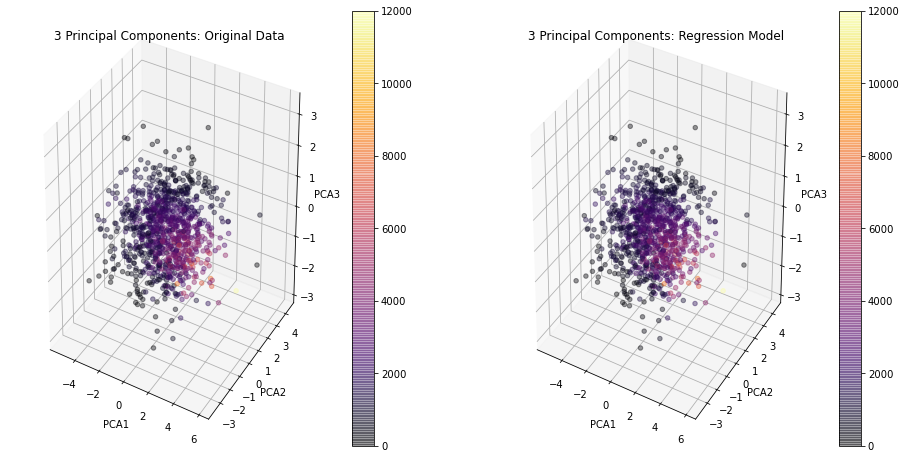

In [23]:
fig_final = plt.figure(figsize=(16,8))

ax_real = fig_final.add_subplot(1,2,1, projection = '3d')
final_real = ax_real.scatter(PCA_data[:,0],PCA_data[:,1],PCA_data[:,2], c=response_feature, marker=None, cmap='inferno', alpha=.4)
final_real.set_clim([0,12000]); fig_final.colorbar(final_real, ax = ax_real)
ax_real.set_title('3 Principal Components: Original Data'); ax_real.set_xlabel('PCA1'); ax_real.set_ylabel('PCA2'); ax_real.set_zlabel('PCA3')

ax_predict = fig_final.add_subplot(1,2,2, projection = '3d')
final_pred = ax_predict.scatter(PCA_data[:,0],PCA_data[:,1],PCA_data[:,2], c=predict_prod[:,-1], marker=None, cmap='inferno', alpha=.4)
final_pred.set_clim([0,12000]); fig_final.colorbar(final_pred,ax = ax_predict)
ax_predict.set_title('3 Principal Components: Regression Model'); ax_predict.set_xlabel('PCA1'); ax_predict.set_ylabel('PCA2'); ax_predict.set_zlabel('PCA3')

plt.show()

### Conclusion

Overall, we can say that the regression analysis performed with polynomial regression was a better approach than the categorical approach with suport vector machines. While these two methods are different in their own right the regression model had a very low MSE, low residual % error, and is computationally fast while the SVM model had low precision particularly when predicting medium production wells. 